<a href="https://colab.research.google.com/github/qayyumu/RL_agents/blob/master/Example_2_DQN_atari_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gym
!pip install keras-rl
!pip install "gym[atari]"
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

    100% |████████████████████████████████| 1.5MB 13.8MB/s 
    100% |████████████████████████████████| 1.0MB 17.3MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym
    100% |████████████████████████████████| 40kB 3.0MB/s 
  Running setup.py bdist_wheel for keras-rl ... - \ done
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl
    100% |████████████████████████████████| 1.2MB 6.3MB/s 
    100% |████████████████████████████████| 1.7MB 10.8MB/s 
  Running setup.py bdist_wheel for PyOpenGL ... - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
Successfully built PyOpenGL
Extracting templates from packages: 100%


In [0]:
from time import sleep
from __future__ import division

import gym
from gym import wrappers 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Permute
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras.activations import relu, linear
from keras.layers.advanced_activations import LeakyReLU

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


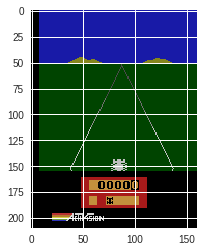

In [0]:
env = gym.make('Enduro-v0')
env = wrappers.Monitor(env, './', force=True) # save animations



plt.imshow(env.render(mode='rgb_array'))

In [0]:
nb_actions = env.action_space.n
print('Total number of Possible actoin is :', nb_actions)

Total number of Possible actoin is : 9


In [0]:
### stack of 4 frames
frame_shape = (84, 84)
window_length = 4
input_shape = (window_length,) + frame_shape
print('Input Shape is :', input_shape)

Input Shape is : (4, 84, 84)


In [0]:
###class for preproc the game frames
class GameProcess(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = np.array(img.resize(frame_shape).convert('L'))
        return img.astype('uint8')  

    def process_state_batch(self, batch):
        Processed_batch = batch.astype('float32') / 255.
        return Processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [0]:
##### Deep mind architecture
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

In [0]:
### memory for exp replay
memory = SequentialMemory(limit=1000000, window_length=window_length)

In [0]:
#### policy for exploration
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)

In [0]:
#### K-rl agent init
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory, processor=GameProcess(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

In [0]:
dqn.compile(Adam(lr=.00025), metrics=['mae'])


In [0]:
from rl.callbacks import FileLogger, ModelIntervalCheckpoint


weights_filename = 'dqn_{}_weights.h5f'.format('test')
checkpoint_weights_filename = 'dqn__weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format('test')
#callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks = [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=1750000, log_interval=10000)

    # After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

Training for 1750000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 72s 7ms/step - reward: 0.0000e+00
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 58s 6ms/step - reward: 0.0000e+00
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 3 (20000 steps performed)
  345/10000 [>.............................] - ETA: 58s - reward: 0.0000e+00done, took 132.259 seconds


In [0]:
dqn.load_weights('dqn_atari_Enduro.h5f')

OSError: ignored

In [0]:
env.reset()

dqn.test(env, nb_episodes=1, visualize=False)

# download videos
from google.colab import files
import glob

for file in glob.glob("*.mp4"):
  files.download(file)
#plt.imshow(env.render(mode='rgb_array'))

env.close()

Error: ignored